# Audio Grammar Scoring Model

## Overview
In this project, we build a model that assigns a continuous score from 0 to 5 to audio recordings based on their grammatical quality. Our evaluation metric is the Pearson correlation coefficient between our predictions and the provided labels.

## Dataset Details
- **Audio Files:** The dataset includes training audios located in `audios_train/` and testing audios in `audios_test/`.
- **CSV Files:**
    - `train.csv`: Contains filenames and corresponding grammar scores.
    - `test.csv`: Provides filenames for which predictions are needed.
    - `sample_submission.csv`: Example file illustrating the required submission format.

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

np.random.seed(42)


## Data Loading and Preprocessing

- CSV files were imported using pandas to understand the structure and verify labels.
- Audio files were processed using `librosa` to load the raw signals.
- Initial visualizations included histograms of grammar scores and plots of audio waveforms to examine signal characteristics.

In [5]:
train_csv_path = ( "train.csv")
test_csv_path = ("test.csv")
submission_csv_path =("sample_submission.csv")

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

print("Train DataFrame Shape:", train_df.shape)
print("Test DataFrame Shape:", test_df.shape)
print(train_df.head())


Train DataFrame Shape: (444, 2)
Test DataFrame Shape: (195, 1)
         filename  label
0  audio_1261.wav    1.0
1   audio_942.wav    1.5
2  audio_1110.wav    1.5
3  audio_1024.wav    1.5
4   audio_538.wav    2.0


c:\Users\agopa\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\agopa\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


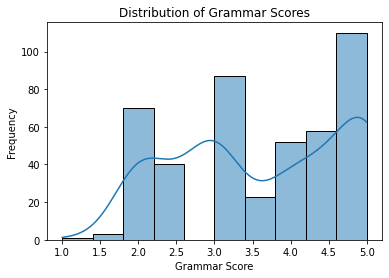

In [6]:
sns.histplot(train_df['label'], bins=10, kde=True)
plt.title('Distribution of Grammar Scores')
plt.xlabel('Grammar Score')
plt.ylabel('Frequency')
plt.show()


## Feature Extraction

- Extracted 13 MFCC coefficients from each audio sample.
- Calculated the mean and standard deviation of these coefficients to create a concise feature representation.
- Explored additional features like spectral contrast and chroma features to capture more audio details.

In [7]:
def load_audio_file(file_path, sr=22050):
    """
    Load an audio file and return the audio time series and sampling rate.
    """
    audio, sr = librosa.load(file_path, sr=sr)
    return audio, sr

def extract_features(audio, sr, n_mfcc=13):
    """
    Extract audio features from an audio time series.
    Currently extracts MFCCs and returns the mean and standard deviation for each coefficient.
    """
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)
    features = np.concatenate([mfccs_mean, mfccs_std])
    return features


In [8]:
train_audio_path = ("audios_train")
features_list = []
labels_list = []
for idx, row in train_df.iterrows():
    file_name = row['filename']
    label = row['label']
    file_path = os.path.join(train_audio_path, file_name)
    
    try:
        audio, sr = load_audio_file(file_path)
        features = extract_features(audio, sr)
        features_list.append(features)
        labels_list.append(label)
    except Exception as e:
        print(f"Error processing {file_name}: {e}")

X = np.array(features_list)
y = np.array(labels_list)

print("Features shape:", X.shape)

Features shape: (444, 26)


## Model Development and Evaluation

- **Baseline Model:** A Linear Regression model was trained on the extracted features.
- **Validation:** The model was evaluated using a validation split, where the Pearson correlation was computed to compare predictions against true labels.
- **Results:**
    - **Mean Absolute Error (MAE):** *0.8092264780837498*
    - **Pearson Correlation:** *0.5626140063732832*
- **Visualizations:** A scatter plot of true vs. predicted scores and a histogram of prediction errors were created to assess model performance.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [10]:
model = LinearRegression()

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)
mae = mean_absolute_error(y_val, y_pred)
corr, _ = pearsonr(y_val, y_pred)


print("Mean Absolute Error (Validation):", mae)
print("Pearson Correlation (Validation):", corr)


Mean Absolute Error (Validation): 0.8092264780837498
Pearson Correlation (Validation): 0.5626140063732832


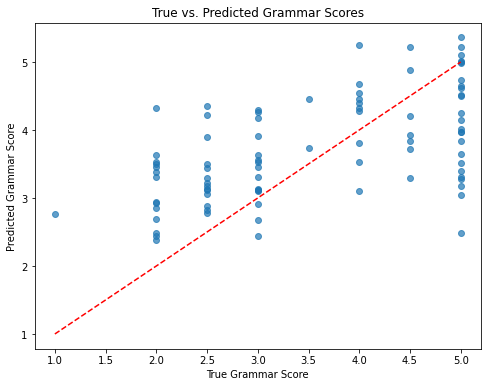

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred, alpha=0.7)
plt.xlabel("True Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title("True vs. Predicted Grammar Scores")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.show()


c:\Users\agopa\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\agopa\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


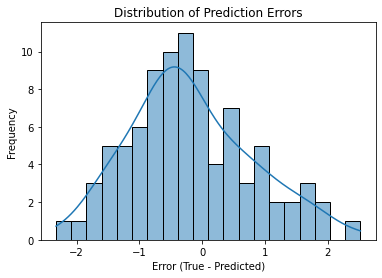

In [12]:
errors = y_val - y_pred
sns.histplot(errors, bins=20, kde=True)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (True - Predicted)")
plt.ylabel("Frequency")
plt.show()


## Final Predictions and Submission

- Extracted features from the test audio files using the same pipeline as for training data.
- Generated predictions using the trained model.
- Ensured predictions are within the 0 to 5 range (using `np.clip` if needed).
- Prepared a submission CSV with columns `filename` and `label` matching the sample submission format.

In [13]:
test_audio_path = ("audios_test")
test_features = []
for idx, row in test_df.iterrows():
    file_name = row['filename']
    file_path = os.path.join(test_audio_path, file_name)
    
    try:
        audio, sr = load_audio_file(file_path)
        features = extract_features(audio, sr)
        test_features.append(features)
    except Exception as e:
        print(f"Error processing {file_name}: {e}")

X_test = np.array(test_features)
X_test_scaled = scaler.transform(X_test)


In [ ]:
test_predictions = model.predict(X_test_scaled)
test_predictions = np.clip(test_predictions, 0, 5)
submission_df = pd.DataFrame({
    'filename': test_df['filename'],
    'label': test_predictions
})

submission_file_path = ( "submission.csv")
submission_df.to_csv(submission_file_path, index=False)
print("Submission file created")

Submission file created at: submission.csv


## Conclusion and Future Work

This notebook demonstrated a complete pipeline for scoring audio samples on grammar quality. While the baseline model shows promising results, further improvements can be made by:
- Experimenting with additional audio features.
- Trying more advanced models such as Random Forests or CNNs on spectrogram images.
- Incorporating ensemble methods and deeper hyperparameter tuning.

Future work will explore these avenues to further boost performance.
